In [1]:
#default_exp umap_all

# UMAP reduction of all COI

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [69]:
# export
import umap
from ehv import core, load as e_load, correlation
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
import uuid
from matplotlib import cm
from sklearn.neighbors import kneighbors_graph
import scipy.spatial.distance
import scipy.sparse
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.feature_selection import VarianceThreshold

In [70]:
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [71]:
df = df[df["meta_label_coi"]]
df.shape

(339045, 113)

In [72]:
with open("data/selected_features_low.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [73]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [74]:
def do_low_variance_filter(df):
    v = VarianceThreshold(0.01).fit(df.filter(regex="feat"))
    cols = df.filter(regex="feat").columns[v.get_support()]
    cols = cols.append(df.filter(regex="meta").columns)
    return df[cols]

df = do_low_variance_filter(df)

In [75]:
df.shape

(339045, 77)

In [76]:
correlated_features = correlation.get_correlated_features(df.filter(regex="feat"), thresh=0.89)
df = df.drop(columns=correlated_features)
df.shape

(339045, 60)

In [88]:
df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))

In [ ]:
df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))

In [77]:
def do_minmax_scale(df):
    df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_minmax_scale)

In [89]:
def do_zscore_scale(df):
    df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_zscore_scale)

In [40]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_robust_scale)

## Compute UMAP on all cells of interest

In [27]:
model = umap.UMAP(densmap=True, random_state=42, metric="cosine")

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95).fit_transform(df.filter(regex="feat"))
pca.shape

(293029, 39)

In [28]:
%%time
projection = model.fit_transform(df.filter(regex="feat"))

CPU times: user 31min 37s, sys: 4min 29s, total: 36min 7s
Wall time: 15min 29s


In [29]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/da648fc6-7bf0-4887-a635-e55aa134329c.dat']

In [77]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/da648fc6-7bf0-4887-a635-e55aa134329c.dat")

In [78]:
df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

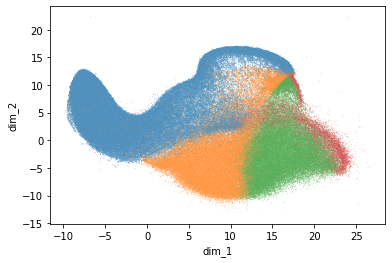

In [79]:
ax = seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.5, alpha=0.5, legend=False, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/da648fc6-7bf0-4887-a635-e55aa134329c.jpg")

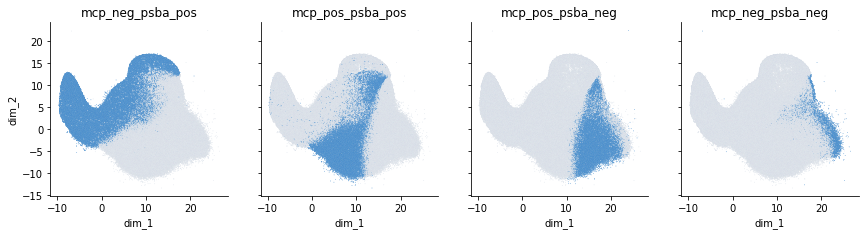

In [127]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"].reset_index(), col="meta_label", col_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
cpal = seaborn.color_palette([(213/255, 221/255, 231/255, 10/255), (29/255, 116/255,195/255)])

for col_name, ax in grid.axes_dict.items():
    ax.set_title(col_name)
    seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue=df["meta_label"]==col_name, s=0.5, ax=ax, legend=False, palette=cpal)

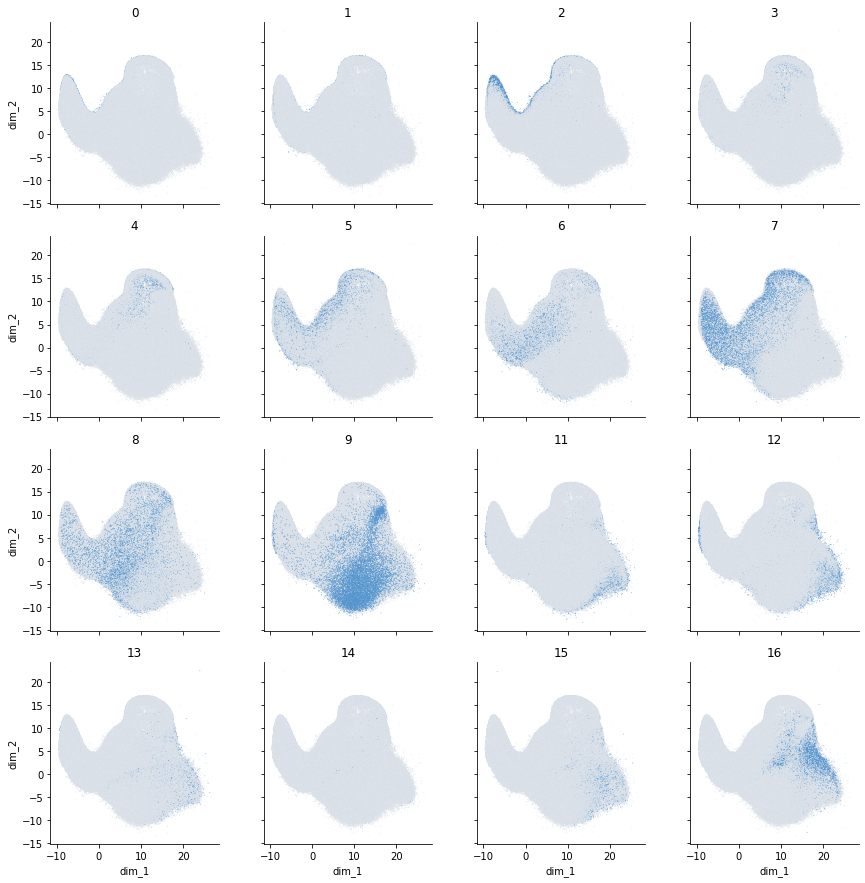

In [129]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"].reset_index(), col_wrap=4, col="meta_timepoint", hue_order=sorted(df["meta_timepoint"].unique()))
cpal = seaborn.color_palette([(213/255, 221/255, 231/255, 10/255), (29/255, 116/255,195/255)])

for col_name, ax in grid.axes_dict.items():
    ax.set_title(col_name)
    seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue=df["meta_timepoint"]==col_name, s=0.5, ax=ax, legend=False, palette=cpal)

In [ ]:
## export
def knn_umap_plot(df, ax, fig=None, colorbar=True, cmap="cool", metric="cosine"):
    knn = scipy.sparse.tril(kneighbors_graph(df.filter(regex="feat"), n_jobs=-1, n_neighbors=5, metric=metric)).toarray()
    dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(df[["dim_1", "dim_2"]], "euclidean"))
    
    norm = matplotlib.colors.Normalize(vmin=dists.min(), vmax=dists.max())
    cmap = cm.get_cmap(cmap)
    for i in range(knn.shape[0]):
        for j in knn[i].nonzero()[0]:
            xx = [df.iloc[i]["dim_1"], df.iloc[j]["dim_1"]]
            yy = [df.iloc[i]["dim_2"], df.iloc[j]["dim_2"]]
            ax.plot(xx, yy, alpha=0.2, c=cmap(norm(dists[i, j])), linewidth=.5)
            
    if colorbar:
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

CPU times: user 51.3 s, sys: 2.48 s, total: 53.8 s
Wall time: 49.2 s


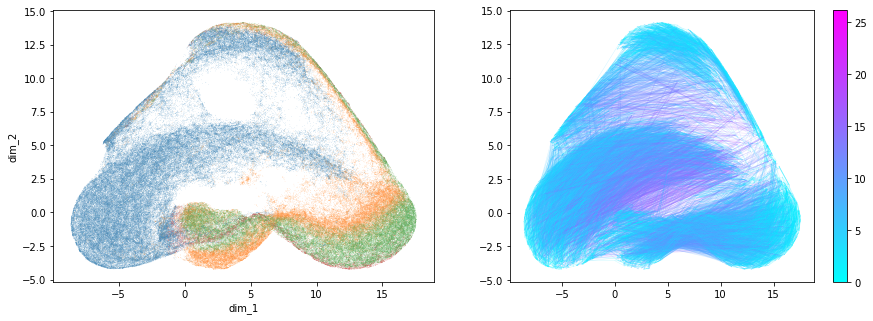

In [176]:
%%time
from sklearn.neighbors import kneighbors_graph
import scipy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.2, alpha=0.5, legend=False, ax=ax1, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])

sample = df.sample(n=10000)
knn_umap_plot(sample, ax2, fig, True)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

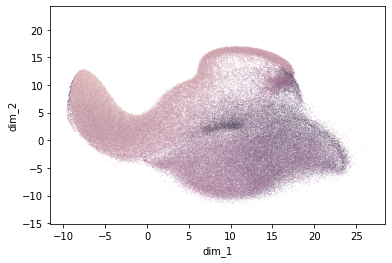

In [32]:
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_timepoint", s=0.2, alpha=0.5, legend=False)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

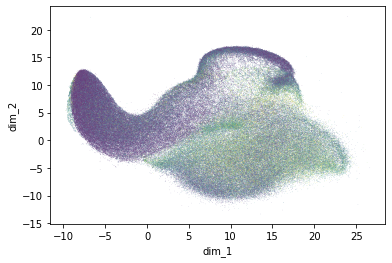

In [33]:
feat = "feat_area_m07"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.2, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

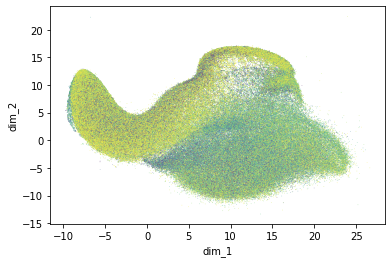

In [34]:
feat = "feat_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

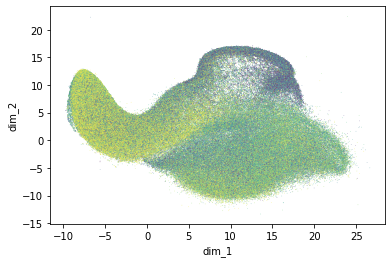

In [35]:
feat = "feat_aspect_ratio_m01"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

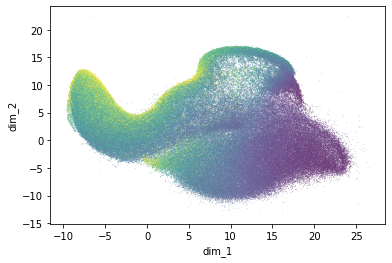

In [36]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

In [37]:
corr = df.filter(regex="feat|dim").corr()

In [115]:
corr["dim_2"].sort_values(ascending=False)[:20]

dim_2                                   1.000000
feat_max_pixel_mc_ssc                   0.600385
feat_intensity_mc_ssc                   0.493827
feat_intensity_mc_ch11                  0.435910
feat_median_pixel_m09_bf2               0.399712
feat_modulation_m06_ssc                 0.370283
feat_max_pixel_mc_ch11                  0.361794
feat_contrast_m09_bf2                   0.322804
feat_contrast_m01_bf                    0.317719
feat_area_m11                           0.270904
feat_max_pixel_mc_bf2                   0.269877
feat_width_m11                          0.256689
feat_aspect_ratio_m11                   0.220214
feat_aspect_ratio_intensity_m11_ch11    0.173676
feat_length_m01                         0.158926
feat_length_m09                         0.151295
feat_gradient_rms_m07_ch7               0.145059
feat_width_m01                          0.117635
feat_width_m09                          0.098290
feat_aspect_ratio_intensity_m07_ch7     0.096633
Name: dim_2, dtype: 

In [116]:
corr["dim_2"].sort_values(ascending=True)[:20]

feat_intensity_mc_ch04                    -0.510493
feat_area_m04                             -0.509752
feat_bright_detail_intensity_r3_mc_ch04   -0.460615
feat_modulation_m04_ch04                  -0.386262
feat_contrast_m04_ch04                    -0.331982
feat_gradient_rms_m11_ch11                -0.295596
feat_bright_detail_intensity_r3_mc_ch03   -0.260192
feat_area_m07                             -0.227368
feat_gradient_rms_m06_ssc                 -0.225195
dim_1                                     -0.207785
feat_aspect_ratio_intensity_m09_bf2       -0.203656
feat_contrast_m11_ch11                    -0.200629
feat_aspect_ratio_intensity_m01_bf        -0.170258
feat_aspect_ratio_m09                     -0.146373
feat_aspect_ratio_m01                     -0.129543
feat_length_m07                           -0.101381
feat_contrast_m06_ssc                     -0.057371
feat_length_m06                           -0.054070
feat_width_m06                            -0.041591
feat_median_

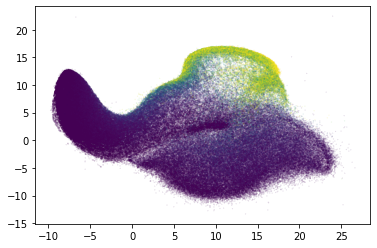

In [39]:
feat = "feat_max_pixel_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, alpha=0.5, cmap="viridis", norm=norm)

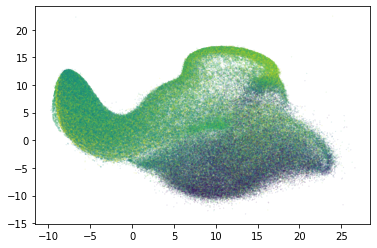

In [118]:
feat = "feat_median_pixel_m09_bf2"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, alpha=0.5, cmap="viridis", norm=norm)

In [40]:
corr["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_intensity_mc_ch11                     0.676038
feat_max_pixel_mc_ch11                     0.612445
feat_area_m04                              0.507989
feat_bright_detail_intensity_r3_mc_ch03    0.464925
feat_modulation_m06_ssc                    0.460581
feat_bright_detail_intensity_r3_mc_ch04    0.424752
feat_intensity_mc_ch04                     0.401129
feat_width_m11                             0.396887
feat_area_m07                              0.382781
feat_modulation_m04_ch04                   0.382360
feat_area_m11                              0.374039
feat_area_mc                               0.366685
feat_area_m06                              0.359481
feat_contrast_m04_ch04                     0.359111
feat_max_pixel_mc_ssc                      0.357282
feat_bright_detail_intensity_r3_mc_bf      0.341440
feat_gradient_rms_m07_ch7                  0.331923
feat_intensity_mc_ssc                      0.330547
feat_aspect_

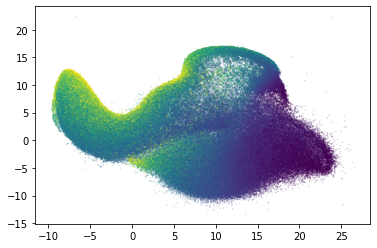

In [41]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, cmap="viridis", norm=norm)